# VinBigData Chest X-ray Abnormalities Detection


Automatically localize and classify thoracic abnormalities from chest radiographs

https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection

# Import Packages


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pathlib
from pprint import pprint

#img
import cv2

#pytorch
import torch
from torch import nn
from torch import functional as F
from torch import optim
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import transforms
from torch.nn import Module
from torchvision import models
from PIL import Image

import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import albumentations as A

#FasterRCNN
#from torchvision.models.detection import FasterRCNN
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection.rpn import AnchorGenerator

#dicom
import pydicom

#set Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# import EfficientDet Packages
[reference]\ 1.github : https://github.com/rwightman/efficientdet-pytorch

2.kaggle : https://www.kaggle.com/shonenkov/training-efficientdet

Import Packages for EfficientDet-pytorch

In [2]:
!pip install timm
!pip install omegaconf
!pip install pycocotools
!pip install effdet


     |████████████████████████████████| 287 kB 864 kB/s eta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272651 sha256=0249409027c83825b57c503421200e0c081d633728f6451478b14517d891ff11
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools
     |████████████████████████████████| 107 kB 870 kB/s eta 0:00:01


## Read CSV Data

In [3]:
#-----path-----
#train csv
train_csv_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
sample_sub_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv")
#dicom data
train_data_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/train")
test_data_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/test")


In [4]:
#train csv
df=pd.read_csv(train_csv_path)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [24]:
#fill NaN
print(df.isnull().sum())
df.fillna(0,inplace=True)

image_id      0
class_name    0
class_id      0
rad_id        0
x_min         0
y_min         0
x_max         0
y_max         0
dtype: int64


In [26]:
#classid
print(df["class_id"].unique())
print("uniques:",len(df["class_id"].unique()))


[14  3  0 11  5  8 13  7  1  9  6 10  2  4 12]
uniques: 15


# Visualize Data

https://www.kaggle.com/nxhong93/yolov5-chest-512

In [46]:
import plotly
import plotly.express as px

def Visualize_class(df, feature, title):
    num_image = df[feature].value_counts().rename_axis(feature).reset_index(name='num_image')
    fig = px.bar(num_image[::-1], x='num_image', y=feature, orientation='h', color='num_image')
    
    #x,yはtitleの位置を変更
    fig.update_layout(
    title={
        'text': title,
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    fig.show()

In [52]:
Visualize_class(df, feature='class_name',
                title='Types of thoracic abnormalities')

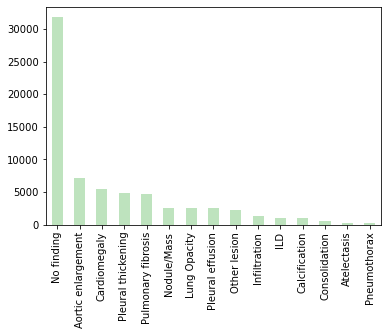

In [61]:
#class_name
df["class_name"].value_counts().plot(kind="bar",
                                     colormap='Accent',
                                    alpha=0.5)
plt.show()

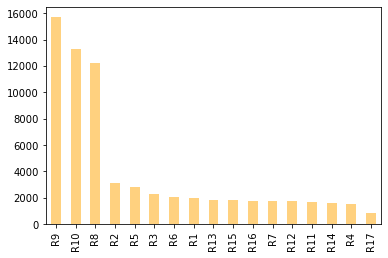

In [62]:
#rad_id
df["rad_id"].value_counts().plot(kind="bar",color="orange",
                                    alpha=0.5)
plt.show()

# Normalize Dicom Image
idea is below
[reference] https://www.kaggle.com/raddar/popular-x-ray-image-normalization-techniques

### [1] No-Normalization
### [2] Histogram normalization
The general idea is to make pixel distribution uniform. This makes X-rays appear a little darker. This generates view, which radiologist would not see in his standard workplace.\ Such normalization is used in popular open-source X-ray datasets, such as CheXpert.

img = read_xray(str(sample_ids))\ img = exposure.equalize_hist(img)

### [3] CLAHE normalization
This method produces sharper images and is quite often used in chest X-ray research. This generates view, which radiologist would not see in his standard workplace. However, it closely resembles the "bone-enhanced" view in some X-rays done (usually due to broken ribs).

img = read_xray(str(sample_ids))\ img = exposure.equalize_adapthist(img/np.max(img))



In [10]:
def read_xray_normalized(image_ids):
    
    #"read dicom data and change type:uint8"
    
    #read dicom data
    ds=pydicom.dcmread(image_ids)
    #->to ndarray
    dcm_arr=ds.pixel_array
    
    #normalize arr
    amin=np.amin(dcm_arr)
    amax=np.amax(dcm_arr)
    scale = 255.0/(amax-amin) # set scale
    arr_rescaled = dcm_arr*scale # >rescale 0-255
    arr_int8 = np.uint8(arr_rescaled) #->uint8
    return arr_int8

In [11]:
#get train image ids
image_ids=[x for x in train_data_path.iterdir() if x.is_file()]
len(image_ids)


15000

# Sample Xray Image

(3170, 2642)


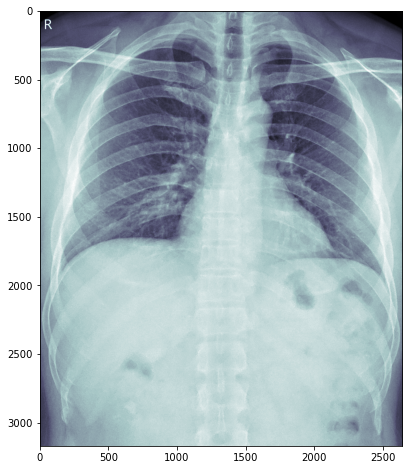

In [12]:
temp_img=read_xray_normalized(image_ids[5])
print(temp_img.shape)
plt.figure(figsize=(8,8))
plt.imshow(temp_img,cmap="bone")
plt.show()

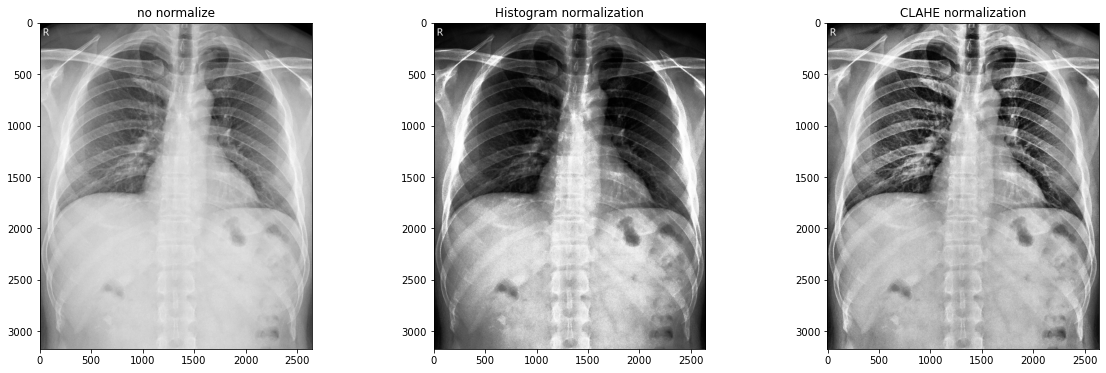

In [13]:
#Histogram normalization(type:ndarray)
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure

dicom_img=read_xray_normalized(image_ids[5])

#複数のグラフを表示するときに、X軸の設定をすべてのグラフで設定するのが面倒な時にShareが使えます。
#subplotsに引数でsharex=Trueとするだけです
#。複数のグラフを表示するときに、X軸の設定をすべてのグラフで設定するのが面倒な時にShareが使えます。
#subplotsに引数でsharex=Trueとするだけ

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(20,6), sharex=False)
ax1.set_title("no normalize")
ax1.imshow( dicom_img,cmap="gray")

ax2.set_title("Histogram normalization")
ax2.imshow(exposure.equalize_hist(dicom_img),cmap="gray")

ax3.set_title("CLAHE normalization")
ax3.imshow(exposure.equalize_adapthist(dicom_img/np.max(dicom_img)),cmap="gray")
plt.show()

# Data Augmentation 

# sample augmentation

In [14]:
#read dicom img
temp_img=read_xray_normalized(image_ids[10])
temp_img.shape

(2861, 2619)

In [15]:
sample_ids=image_ids[10]
print(image_ids[10])
print("file name:",sample_ids.stem)
print("suffix:",sample_ids.suffix)

../input/vinbigdata-chest-xray-abnormalities-detection/train/98617a2bbd11c4afa7be664889cdd6de.dicom
file name: 98617a2bbd11c4afa7be664889cdd6de
suffix: .dicom


In [16]:
#dataの取得
data=df[df["image_id"]==image_ids[10].stem]
data.reset_index(inplace=True)
data.head()

,index,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,21851,98617a2bbd11c4afa7be664889cdd6de,Lung Opacity,7,R9,655.0,368.0,1178.0,708.0
1,25349,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R8,915.0,403.0,1220.0,777.0
2,28931,98617a2bbd11c4afa7be664889cdd6de,Nodule/Mass,8,R10,2240.0,1657.0,2312.0,1738.0
3,39495,98617a2bbd11c4afa7be664889cdd6de,Pulmonary fibrosis,13,R9,694.0,1669.0,935.0,1916.0
4,43174,98617a2bbd11c4afa7be664889cdd6de,Pleural thickening,11,R9,1510.0,352.0,2119.0,675.0


In [17]:
#bounding box
box_col=["x_min","y_min","x_max","y_max"]
bboxes = data[box_col].values.astype(np.float32)

#labels:
labels=data["class_id"].tolist()

image=temp_img.astype(np.float32)

In [18]:
#albumenationsを用いたboundingboxと共に変換する方法の参考例
resize_transform = A.Compose([A.Resize(height=512, width=512, p=1.0)], 
                                    p=1.0, 
                                    bbox_params=A.BboxParams(
                                        format='pascal_voc',
                                        min_area=0.1, 
                                        min_visibility=0.1,
                                        label_fields=['labels'])
                                    )

In [19]:
transformed=resize_transform(image=image,
                             bboxes=bboxes,
                             labels=labels
                            )

In [21]:
#出力確認
from pprint import pprint
pprint(transformed["image"].shape)
pprint(transformed["bboxes"])
pprint(transformed["labels"])

(512, 512)
[(128.04887361588393, 65.85669346382383, 230.29247804505536, 126.7025515554002),
 (178.87743413516608, 72.12023767913317, 238.5032455135548, 139.0506815798672),
 (437.90759831996945, 296.53407899335895, 451.9831996945399, 311.0297098916463),
 (135.67315769377626, 298.6815798671793, 182.7873234058801, 342.884306186648),
 (295.196639938908, 62.993358965396716, 414.25276823214966, 120.79692415239427),
 (295.196639938908, 62.993358965396716, 414.25276823214966, 120.79692415239427),
 (128.04887361588393, 65.85669346382383, 230.29247804505536, 126.7025515554002),
 (131.56777395952653,
  103.25900034952814,
  148.1848033600611,
  117.21775602936036),
 (292.4597174494082, 64.78294302691367, 343.0927835051546, 144.77735057672143)]
[7, 11, 8, 13, 11, 7, 11, 8, 11]


In [23]:
#参考[使用はしてない]
#https://www.kaggle.com/sreevishnudamodaran/effdet-pytorch-cutmix-mixup-kfold-cosanneal

import albumentations as A


def get_train_transforms():
    return A.Compose(
        [
        ## RandomSizedCrop not working for some reason. I'll post a thread for this issue soon.
        ## Any help or suggestions are appreciated.
#         A.RandomSizedCrop(min_max_height=(300, 512), height=512, width=512, p=0.5),
#         A.RandomSizedCrop(min_max_height=(300, 1000), height=1000, width=1000, p=0.5),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                 val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, p=0.9),
        ],p=0.9),
        A.JpegCompression(quality_lower=85, quality_upper=95, p=0.2),
        A.OneOf([
            A.Blur(blur_limit=3, p=1.0),
            A.MedianBlur(blur_limit=3, p=1.0)
            ],p=0.1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.Resize(height=512, width=512, p=1),
        A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
        ToTensorV2(p=1.0)
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [ ]:
#albumentationsを用いない場合は以下
def resize(image, boxes, width, height):
    # 現在の高さと幅を取得しておく
    c_height, c_width = image.shape[:2]
    img = cv2.resize(image, (width, height))
    
    # 圧縮する比率(rate)を計算
    r_width = width / c_width
    r_height = width / c_height
    
    # 比率を使ってBoundingBoxの座標を修正
    new_boxes = []
    for box in boxes:
        x,y,w,h=box
        x = int(x * r_width)
        y = int(y * r_height)
        w = int(w * r_width)
        h = int(h * r_height)
        new_box =[x, y, w, h]
        new_boxes.append(new_box)
    return img, new_boxes

# class_id:14に該当するデータを排除する。

class_id=14：該当なしのデータを取り除いて学習させる。

In [12]:
df_annotation= df[df['class_id']!=14].reset_index(drop=True)
df_annotation

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0


# bounding boxのerrorを調べておく。

#x_min>x_max,y_min>y_maxなどになっている場合など、alubmentationがエラーとなるため調べておく


In [14]:
#x_min>x_max,y_min>y_maxなどになっている場合など、alubmentationがエラーとなるため調べておく
index_names=df_annotation[(df_annotation["x_min"]>df_annotation["x_max"]) | (df_annotation["y_min"]>df_annotation["y_max"])]
print(len(index_names))

0


In [15]:
df_annotation

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0


## DataLoader

In [22]:
class My_Dataset(Dataset):
    def __init__(self,df,):
        
        #dataframeを格納する
        self.df = df
        self.image_ids=df["image_id"].unique()
        self.image_dir=pathlib.\
                    Path("../input/vinbigdata-chest-xray-abnormalities-detection/train")
        #columnsを設定する
        self.box_col=["x_min","y_min","x_max","y_max"]
        #transform
        self.transform= A.Compose([A.Resize(height=512, width=512, p=1.0)], 
                                    p=1.0, bbox_params=A.BboxParams(
                                        format='pascal_voc',
                                        min_area=0.1, 
                                        min_visibility=0.1,
                                        label_fields=['labels']))
        
        self.gray_to_rgb=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        ]) 
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self,index,transform=False):
        
        #get dicom_arr
        image_id=self.image_ids[index]
        image=read_xray_normalized(str(self.image_dir/image_id)+".dicom")
        #print(image.shape)
        
        #target
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        
        #----labels-----
        #labels = records["class_id"].tolist()
        transformed=self.transform(image=image.astype(np.float32),
                             bboxes=records[self.box_col].values.astype(np.float32),
                             labels=records["class_id"].tolist()
                            )

        
        #-----[target]:dict-----
        target = {}
        target['resized_bboxes'] =torch.tensor(transformed["bboxes"])
        target['labels'] = torch.tensor(transformed["labels"])
        target["image_row_shape"]=torch.tensor(image.shape)
        target["dicom_id"]=image_id
    
        #Transoformed Image
        #transform
        
        #----area-----
        #bbox:[x,y,w,h] and area=(w-x)*(h-y)
        #area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        #area = area.astype(np.float32)
        image=transformed["image"]
        image=self.gray_to_rgb(image.astype(np.float32))
    
        return image,target

In [23]:
#change collate_fn
def collate_fn(batch):
    imgs, targets= list(zip(*batch))
    
    imgs = torch.stack(imgs)
    targets = list(targets)
    
    return imgs,targets

In [24]:
train_dataset=My_Dataset(df=df_annotation)
train_dataloader=DataLoader(train_dataset,
                            batch_size=2,shuffle=True, collate_fn=collate_fn )

# Sample Output Test
image,target=next(iter(train_dataloader))

In [28]:
print("[image_size]:",image.shape)
pprint(target[0])

[image_size]: torch.Size([2, 3, 512, 512])
{'dicom_id': '21cc15968368582b548bdc50f24d1ce5',
 'image_row_shape': tensor([2880, 2304]),
 'labels': tensor([ 9, 10, 10, 10]),
 'resized_bboxes': tensor([[258.0000, 121.9556, 440.2222, 360.5333],
        [258.0000, 121.9556, 440.2222, 360.5333],
        [257.7778, 125.3333, 426.4444, 340.9778],
        [251.7778, 129.4222, 435.7778, 353.6000]], dtype=torch.float64)}


# EfficientDet Model

In [29]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain,DetBenchPredict
from effdet.efficientdet import HeadNet


config = get_efficientdet_config('tf_efficientdet_d1')
config.image_size = [512,512]
config.norm_kwargs=dict(eps=.001, momentum=.01)

#BackBone=True
net = EfficientDet(config, pretrained_backbone=True)

#default 90 -> classes
net.reset_head(num_classes=15)
net.class_net = HeadNet(config, num_outputs=config.num_classes)


#[MODE]:Train
net=DetBenchTrain(net, config)
net.train()
print("Loaded pretrained weights")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_aa-ea7a6ee0.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_aa-ea7a6ee0.pth


Loaded pretrained weights


In [30]:
print(net.config)

{'name': 'tf_efficientdet_d1', 'backbone_name': 'tf_efficientnet_b1', 'backbone_args': {'drop_path_rate': 0.2}, 'image_size': [512, 512], 'num_classes': 15, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 4, 'fpn_channels': 88, 'separable_conv': True, 'apply_bn_for_resampling': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'pooling_type': None, 'redundant_bias': True, 'head_bn_level_first': False, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'new_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'url': 'https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d1_4

# AverageMeter

epochごとのlossの値を確保するclass
普通にepochごとのlossを取得するほうがわかりやすい気がする。
結局使用してない。

In [31]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [32]:
train_dataset=My_Dataset(df=df_annotation)
train_dataloader=DataLoader(train_dataset,
                            batch_size=2,shuffle=True, collate_fn=collate_fn )

# Sample Output Test
image,target=next(iter(train_dataloader))

print(image.shape)
print(target)

torch.Size([2, 3, 512, 512])
[{'resized_bboxes': tensor([[162.1158, 280.2893, 426.8419, 345.9162],
        [162.7466, 280.2893, 430.2062, 362.4146],
        [161.2747, 285.2388, 427.2624, 339.6835],
        [268.5109, 175.6162, 325.2830, 218.8786],
        [ 72.9626, 101.9234, 227.5088, 243.4429]], dtype=torch.float64), 'labels': tensor([3, 3, 3, 0, 7]), 'image_row_shape': tensor([2793, 2435]), 'dicom_id': '6e1a6f52b179c14edd1af37ead978cb2'}, {'resized_bboxes': tensor([[326.9543, 113.6667, 397.9087, 196.3333],
        [319.4961, 119.3333, 393.6756, 223.5000],
        [319.4961, 119.3333, 393.6756, 223.5000],
        [309.8205,  84.6667, 347.3134,  93.8333]], dtype=torch.float64), 'labels': tensor([13, 13,  6, 11]), 'image_row_shape': tensor([3072, 2540]), 'dicom_id': '84baca7ccea00d8087be7b834603a5db'}]


In [33]:
summary_loss = AverageMeter()

net.train()
for i in range(1):
    images,targets=next(iter(train_dataloader))
    #print(images)
    #print(images.shape)
    #print(targets)
    
    batch_size = images.shape[0]
    
    boxes = [target['resized_bboxes'].to(device).float() for target in targets]
    labels = [target['labels'].to(device).float() for target in targets]
    print("images:",images.shape)
    print("boxes:",boxes)
    print("labels:",labels)
    
    images=images.to(device)
    net=net.to(device)

    #train
    target_dict={}
    target_dict["bbox"]=boxes
    target_dict["cls"]=labels
    output=net(images,target_dict)
    print(output)
    loss=output["loss"]
    
    #loss.backward()
    summary_loss.update(loss.detach().item(), batch_size)

print("summary_loss:average",summary_loss.avg)

images: torch.Size([2, 3, 512, 512])
boxes: [tensor([[ 53.8405, 221.2585, 195.5584, 365.6588],
        [258.4754,  92.1911, 452.1773, 411.6573],
        [ 28.6737,  85.7862, 213.9178, 395.3541],
        [370.2820, 313.4496, 444.7510, 394.5777],
        [321.8050, 208.4488, 436.2933, 392.2487]]), tensor([[ 81.9589, 300.3443, 114.5157, 356.3868],
        [ 76.1278, 305.6040, 214.9396, 400.8218],
        [ 81.9589, 300.3443, 114.5157, 356.3868],
        [ 58.1487, 216.5526,  85.0364, 247.2037],
        [ 71.4306, 307.5990, 218.6650, 414.6057],
        [ 71.4306, 307.5990, 218.6650, 414.6057]])]
labels: [tensor([ 5.,  5.,  5., 13.,  5.]), tensor([11.,  9., 10.,  9., 10.,  9.])]
{'loss': tensor(1199.8199, grad_fn=<AddBackward0>), 'class_loss': tensor(1197.0126, grad_fn=<SumBackward1>), 'box_loss': tensor(0.0561, grad_fn=<SumBackward1>)}
summary_loss:average 1199.8199462890625


# Train

# lossの出力を定義

efficientdetはTrain設定の場合

In [34]:
from torch import Tensor as tensor

def train_loss(images,targets):
   
    batch_size = images.shape[0]
    
    boxes = [target['resized_bboxes'].to(device).float() for target in targets]
    labels = [target['labels'].to(device).float() for target in targets]
    
    img_scale = torch.Tensor([1.0] * batch_size)
    img_size = torch.Tensor([images[0].shape[-2:]] * batch_size,)
    
    target_dict={}
    target_dict["bbox"]=boxes
    target_dict["cls"]=labels
    #target_dict["img_scale"]=img_scale
    #target_dict["img_size"]=img_size
    
    images=images.to(device)
    train_output=net(images,target_dict)

    return train_output

In [35]:
def validation_loss(images,targets):
   
    batch_size = images.shape[0]
    
    boxes = [target['resized_bboxes'].to(device).float() for target in targets]
    labels = [target['labels'].to(device).float() for target in targets]

    img_scale = torch.Tensor([1.0] * batch_size)
    img_size = torch.Tensor([images[0].shape[-2:]] * batch_size,)

    target_dict={}
    target_dict["bbox"]=boxes
    target_dict["cls"]=labels
    target_dict["img_scale"]=img_scale.to(device)
    target_dict["img_size"]=img_size.to(device)
    
    with torch.no_grad():
        images=images.to(device)
        val_output=net(images,target_dict)
        
    return val_output

In [56]:
def train_model(net, dataloaders_dict,optimizer, num_epochs):

    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ移行
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    
    #dict形式で出力値を保存
    hist={"loss":[],"train_class_loss":[],"train_box_loss":[],
            "val_loss":[],"val_class_loss":[],"val_box_loss":[]
         }
    
    # epochのループ
    for epoch in tqdm_notebook(range(num_epochs)):
        print('---Epoch {}/{}---'.format(epoch+1, num_epochs))
        #print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_class_loss = 0.0 
            epoch_box_loss= 0.0
            
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm_notebook(dataloaders_dict[phase]):

                # optimizerを初期化
                optimizer.zero_grad()
                
                if phase=="train":
                    output=train_loss(images,targets)
                    #efficientdetのloss outputは３種類:loss,class_loss,box_loss
                    loss=output["loss"]
                    class_loss=output["class_loss"]
                    box_loss=output["box_loss"]
                    
                    loss.backward()
                    optimizer.step()

                if phase=="val":
                    output=validation_loss(images,targets)
                    #efficientdetのloss outputは３種類
                    loss=output["loss"]
                    class_loss=output["class_loss"]
                    box_loss=output["box_loss"]
                    
                    
                # 結果の計算
                epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                epoch_class_loss += class_loss.item() * inputs.size(0)
                epoch_box_loss += box_loss.item() * inputs.size(0)
                
            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_class_loss = epoch_class_loss / len(dataloaders_dict[phase].dataset)
            epoch_box_loss = epoch_box_loss / len(dataloaders_dict[phase].dataset)
            
            if phase=="train":
                hist["loss"].append(epoch_loss)
                hist["train_class_loss"].append(epoch_class_loss)
                hist["train_box_loss"].append(epoch_box_loss)
            else:
                hist["val_loss"].append(epoch_loss)
                hist["val_class_loss"].append(epoch_class_loss)
                hist["val_box_loss"].append(epoch_box_loss)

            print('{} Loss: {:.4f} '.format(phase, epoch_loss,))
            
    return hist

In [57]:
from sklearn.model_selection import train_test_split
test_size=0.2
df_train,df_val=train_test_split(df_annotation,test_size=test_size,
                                random_state=64)

#分割を確認
print(df_train.shape)
print(df_val.shape)

(28876, 8)
(7220, 8)


# データを減らしてLossが低下するかを試す。

test_sampleとして学習させないdf_trainっデータを抽出しておいて評価に用いる。
lossは低下することを確認。

In [58]:
# TEST CODE
# test sample with reducing data
df_train=df_train[:100]
df_val=df_val[:50]
# test評価用にサンプルをとっておく
test_sample=df_train[:-100]

In [59]:
#DataSet
train_dataset=My_Dataset(df_train)
val_dataset=My_Dataset(df_val)

#Dataloader
batch_size=5
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False,collate_fn=collate_fn)

#dict
dataloaders_dict={"train":train_dataloader,"val":val_dataloader}

# Train Model

In [60]:
from tqdm.notebook import tqdm_notebook

learning_rate=1e-3
num_epochs=10
#-----optimizer-----
optimizer=torch.optim.AdamW(net.parameters(), lr=learning_rate)

In [61]:
#-----train model-----
#正答率、損失関すのグラフまで出力
hist=train_model(net=net,
            dataloaders_dict=dataloaders_dict,
            optimizer=optimizer,
            num_epochs=num_epochs)

使用デバイス： cpu


  0%|          | 0/10 [00:00<?, ?it/s]

---Epoch 1/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 994.0695 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 1113.4282 
---Epoch 2/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 535.4784 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 976.1731 
---Epoch 3/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 175.9227 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 744.8733 
---Epoch 4/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 49.3827 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 530.3497 
---Epoch 5/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 19.7510 


  0%|          | 0/10 [00:00<?, ?it/s]

train Loss: 11.2329 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 280.0492 
---Epoch 7/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 7.6443 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 206.7990 
---Epoch 8/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 5.6934 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 153.4033 
---Epoch 9/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 4.4794 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 114.3580 
---Epoch 10/10---


  0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 3.6557 


  0%|          | 0/10 [00:00<?, ?it/s]

val Loss: 85.0987 


# plot Loss curve

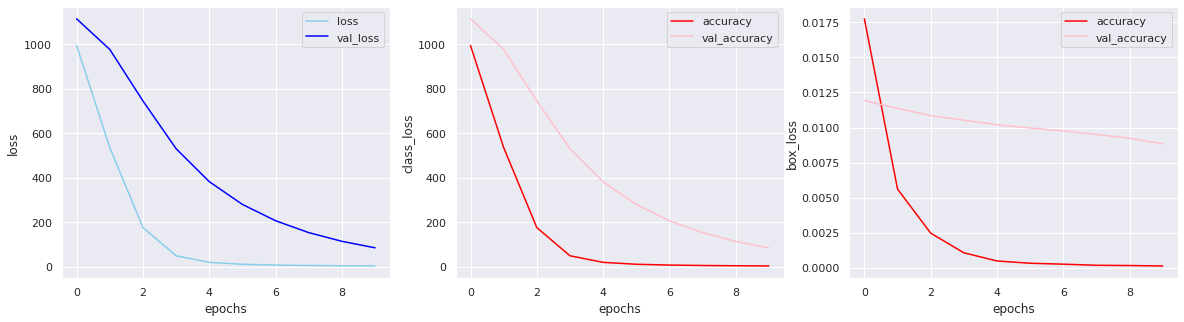

In [62]:
#-----plot loss-----
import seaborn as sns
sns.set()

#fig
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(20,5), sharex=False)

#loss
ax1.plot(hist["loss"],color="skyblue",label="loss")
ax1.plot(hist["val_loss"],color="blue",label="val_loss")
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

#class_loss
ax2.plot(hist["train_class_loss"],color="red",label="accuracy")
ax2.plot(hist["val_class_loss"],color="pink",label="val_accuracy")
ax2.set_xlabel('epochs')
ax2.set_ylabel('class_loss')
ax2.legend()

#box loss
ax3.plot(hist["train_box_loss"],color="red",label="accuracy")
ax3.plot(hist["val_box_loss"],color="pink",label="val_accuracy")
ax3.set_xlabel('epochs')
ax3.set_ylabel('box_loss')
ax3.legend()
plt.show()

# Save Model

In [63]:
torch.save(net.state_dict(),"temp0.pth")